In [1]:
import sys

if "/Users/shvimas/GitHub/diploma/src" not in sys.path:
    sys.path.append("/Users/shvimas/GitHub/diploma/src")

In [2]:
%matplotlib inline
import matplotlib.pyplot as pl
import data_helpers as dh
import helper_funcs as hf
import heston_pricing as he
from pars_range import Range
from importlib import reload, _RELOADING


pl.style.use('ggplot')
pl.rcParams["figure.figsize"] = (15, 10)

In [3]:
pl.rcParams["figure.figsize"] = (15, 10)

In [4]:
%reload_ext autoreload
%autoreload

In [5]:
try:
    data, info = hf.read_data("../SPH2_031612.csv")
except FileNotFoundError:
    data, info = hf.read_data("SPH2_031612.csv")

In [6]:
data, info = dh.prepare_data(data=data, info=info)

In [7]:
data.strikes[True][0]

array([ 1010.,  1020.,  1025.,  1030.,  1040.,  1050.,  1060.,  1070.,
        1075.,  1080.,  1090.,  1100.,  1110.,  1120.,  1125.,  1130.,
        1140.,  1150.,  1160.,  1170.,  1175.,  1180.,  1190.,  1200.,
        1210.,  1220.,  1225.,  1230.,  1240.,  1250.,  1260.,  1270.,
        1275.,  1280.,  1290.,  1300.,  1310.,  1320.,  1325.,  1330.,
        1340.,  1350.,  1360.,  1370.,  1375.,  1380.,  1390.,  1400.,
        1410.,  1420.,  1425.,  1430.,  1440.,  1450.,  1460.])

In [6]:
num = 20
kappa_range = Range(min=2, max=10, num=num)
theta_range = Range(min=1e-6, max=1, num=num)
sigma_range = Range(min=1e-6, max=1, num=num)
rho_range = Range(min=0, max=1, num=num)
v0_range = Range(min=1e-6, max=1, num=num)

In [8]:
day = 0
rate = .03
q = rate
maturity = info[day].mat
spot = info[day].spot
is_call = True
strikes = data.strikes[is_call][day]
prices = data.prices[is_call][day]

args = (spot, strikes, maturity, rate, q, is_call)

In [8]:
pars = (4.2216740989, 0.0199176675743, 1.51769128617e-05, 0.0474806534178, 0.000569295223402)

kappa_range[0], *pars[1:]


(2.0, 0.0199176675743, 1.51769128617e-05, 0.0474806534178, 0.000569295223402)

In [11]:
predicted_kappa = []
kappas = kappa_range
for kappa in kappas:
    pars = kappa, *(pars[1:])
    x = strikes
    y = he.price_heston(pars=pars, args=args)
    predicted_kappa.append(x)
    predicted_kappa.append(y)

kappas[:]

[2.0,
 2.4210526315789473,
 2.8421052631578947,
 3.263157894736842,
 3.6842105263157894,
 4.105263157894736,
 4.526315789473684,
 4.947368421052632,
 5.368421052631579,
 5.789473684210526,
 6.2105263157894735,
 6.631578947368421,
 7.052631578947368,
 7.473684210526315,
 7.894736842105263,
 8.31578947368421,
 8.736842105263158,
 9.157894736842104,
 9.578947368421051,
 10.0]

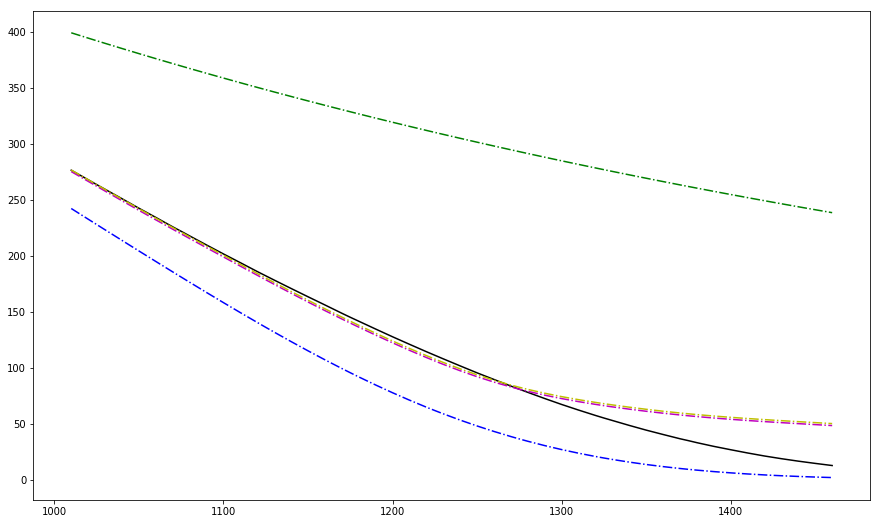

In [22]:
p = pl.plot(  # *predicted_kappa, 
    strikes, data.prices[is_call][day], "k-",
    strikes, he.price_heston(args=args, pars=(9.694173546591017, 0.24630610188128582, 0.8332571621596554, 
                                              0.9693685064163662, 0.4801388745409953)), "g-.",
    strikes, he.price_heston(args=args, pars=(5.10944827e+00, 5.93251547e-03, 2.81152494e-05,
                                              4.93769921e-02, 1.01083722e-03)), "b-.",
    strikes, he.price_heston(args=args, pars=(0.07113125,  0.11028212,  2.0111178,  
                                              0, 0.09534668)), "m-.",
    strikes, he.price_heston(args=args, pars=(0.03004374455815602, 0.02711322443113005, 1.9746283135615887, 
                                              0.00019123809579942708, 0.10315832344591712)), "y-.")

In [19]:
from structs import EvalArgs


new_args = EvalArgs.from_tuple(args)
new_args.r = .001
new_args.q = .001
predicted = he.price_heston(args=new_args.as_tuple(), 
                            pars=(9.694173546591017, 0.24630610188128582, 0.8332571621596554, 
                                  0.9693685064163662, 0.4801388745409953))

In [20]:
from optimization import robust_mean_ratio

robust_mean_ratio(predicted, prices)

4.399280350915767

In [11]:
from importlib import reload
import heston_pricing as he
from structs import EvalArgs
import modeling
modeling = reload(modeling)
he = reload(he)

In [18]:
res = modeling.tune_model(args=EvalArgs.from_tuple(args),
                          model="heston", metric="MAR", prices=prices, 
                          bounds=((.01, 6), (.0001, 1), (1.5e-7, 3), (0, 1), (5e-6, 1)))


In [19]:
res

     fun: 1.0884918034416657
     jac: array([ 0.00170992,  0.07555159, -0.00034515,  0.13998096,  0.06375647])
 message: 'Optimization terminated successfully.'
    nfev: 2175
     nit: 24
 success: True
       x: array([ 0.8394815 ,  0.03088356,  2.57097933,  0.        ,  0.11774668])

In [23]:
from optimization import mean_absolute_error
predicted = he.price_heston(pars=(2.76000138e-01, 1.00000000e-04, 8.19074054e-01, 1.00000000e+00, 1.00000000e-01),
                            args=args)
mean_absolute_error(predicted, prices)
predicted.flatten().shape


(45,)

In [10]:
res = modeling.tune_model(args=EvalArgs.from_tuple(args),
                          model="heston", metric="MAE", prices=prices, 
                          bounds=((.1, 6), (.0001, .03), (1.5e-7, 3), (0, 1), (5e-6, 1e-1)))


In [11]:
res

     fun: 4.986386452082709
     jac: array([  0.75808275,  -0.03873213,  -0.02673097,  10.08315769,   1.26953514])
 message: 'Optimization terminated successfully.'
    nfev: 4179
     nit: 50
 success: True
       x: array([ 0.10620628,  0.02527766,  1.80945962,  0.        ,  0.09975204])

In [22]:
%reload_ext autoreload
%autoreload 2

In [9]:
import os
os.chdir('..')

In [10]:
import warnings
warnings.filterwarnings("ignore", message='numpy.dtype size changed')
warnings.filterwarnings("ignore", message="numpy.ufunc size changed")
warnings.filterwarnings('ignore', message="can't resolve package from __spec__ or __package__, ")

In [20]:
import data_helpers as dh
import numpy as np
import sklearn.decomposition as de


dh = reload(dh)
print(_RELOADING)


centers1 = np.array(dh.get_tuned_params(model1='vg', model2='heston', drop_bad=True))

pca1 = de.PCA(n_components=2)
pca1.fit(centers1)
print(pca1.explained_variance_ratio_)
components1 = pca1.components_
print(components1)

centers2 = np.array(dh.get_tuned_params(model1='ls', model2='heston', drop_bad=True))

pca2 = de.PCA(n_components=2)
pca2.fit(centers2)
print(pca2.explained_variance_ratio_)
components2 = pca2.components_
print(components2)

{}
[ 0.99767701  0.0016959 ]
[[ 0.99992528 -0.00234115  0.00691525  0.00961501  0.00191992]
 [ 0.00516564 -0.01730203 -0.97321     0.18542857 -0.13473122]]


FileNotFoundError: [Errno 2] No such file or directory: 'params/tune_heston_with_ls.txt'

15
15


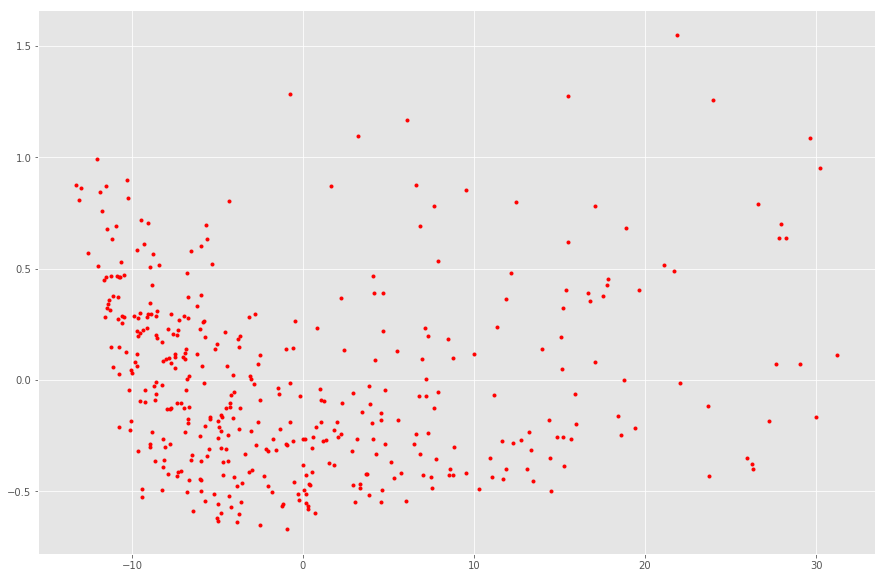

In [21]:
centers1_2d = pca1.fit_transform(centers1)
centers2_2d = pca2.fit_transform(centers2)
dh.plot_dots(a=centers1_2d, style1='r.', style2='b.')
#dh.plot_dots(a=centers1_2d, b=centers2_2d, style1='r.', style2='b.')

print(sum(list(map(
    lambda x: he.bad_pars(*x, bounds_only=True),
    centers1_2d @ components1 + pca1.mean_
))))

print(sum(list(map(
    lambda x: he.bad_pars(*x, bounds_only=True),
    centers2_2d @ components2 + pca2.mean_
))))

In [26]:
def restore_pars(dots, factors, means):
    return dots @ factors + means

q = list(map(lambda x: he.bad_pars(*x, bounds_only=True), centers))
sum(q) / len(q)

0.0

In [27]:
print(components)
print(centers[:10])

[[ 0.99992869 -0.00288585  0.00515419  0.01020162  0.00191184]
 [ 0.00354552 -0.01309603 -0.98416052  0.16006039 -0.07499775]]
[[  9.02008299e+00   2.52444568e-02   1.80768107e+00  -3.44713517e-01
    1.90331499e-02]
 [  9.11645892e+00   3.34380764e-02   1.97549692e+00  -4.36581567e-01
    7.19259244e-03]
 [  6.05261061e+00   3.37956381e-02   1.43958212e+00  -5.15327201e-01
    4.13542099e-02]
 [  1.59317271e+00   1.00000000e-07   5.12469120e-01  -5.86893969e-01
    6.82018298e-02]
 [  8.12353731e+00   4.35032632e-02   1.94623927e+00  -6.38631814e-01
    7.89392988e-02]
 [  6.24813343e+00   6.47295841e-02   1.69593275e+00  -6.94763766e-01
    2.97599160e-02]
 [  6.13862387e+00   5.29442919e-02   1.58118136e+00  -7.46114275e-01
    1.10111921e-01]
 [  6.91169539e+00   2.70755205e-02   1.76181428e+00  -7.59696049e-01
    2.76784945e-01]
 [  4.86060349e+00   9.37253434e-05   1.17621538e+00  -8.07696033e-01
    3.08674004e-01]
 [  5.11314136e+00   1.24498769e-01   1.69778974e+00  -8.529441

In [36]:
import data_helpers as dh
with open('params/pca_heston.txt', 'w') as f:
    f.writelines([f"{-13}, {33}, {-0.7}, {1.5}\n",
                  f"[{dh.array2str(components[0])}], [{dh.array2str(components[1])}]\n",
                  f"{dh.array2str(pca.mean_)}\n"])

In [18]:
dots = dh.get_tune_params(model1='vg', model2='heston')

In [33]:
from gen_pricer import GenPricer
from structs import EvalArgs
plots_call, plots_put = [], []
pricer = GenPricer(model='heston', market=EvalArgs.from_structure(data=data, info=info, rate=.008, day=0), use_fft=True)

for p in dots:
    plots_call.append(data.strikes[True][0])
    plots_put.append(data.strikes[False][0])
    plots_call.append(pricer.price(pars=p)[0])
    plots_put.append(pricer.price(pars=p)[1])

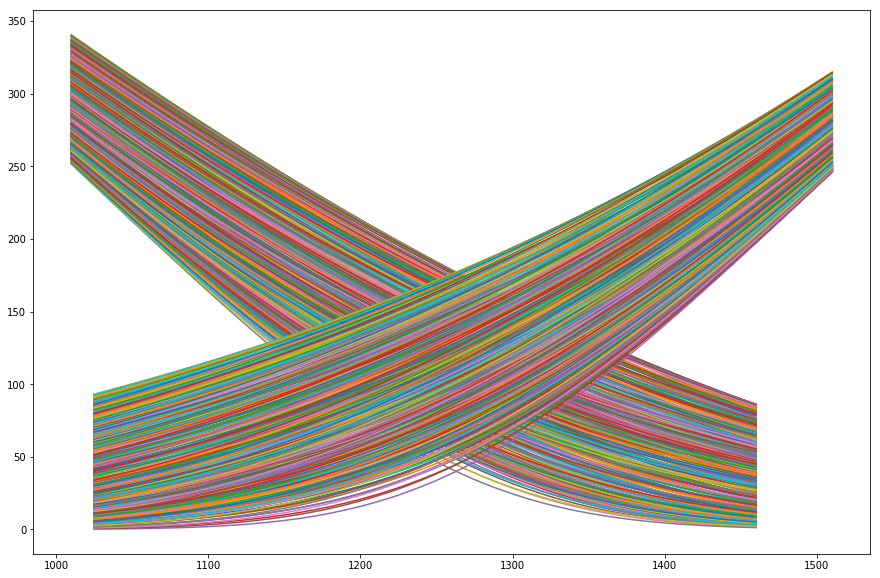

In [35]:
p = pl.plot(*plots_call)
p = pl.plot(*plots_put)

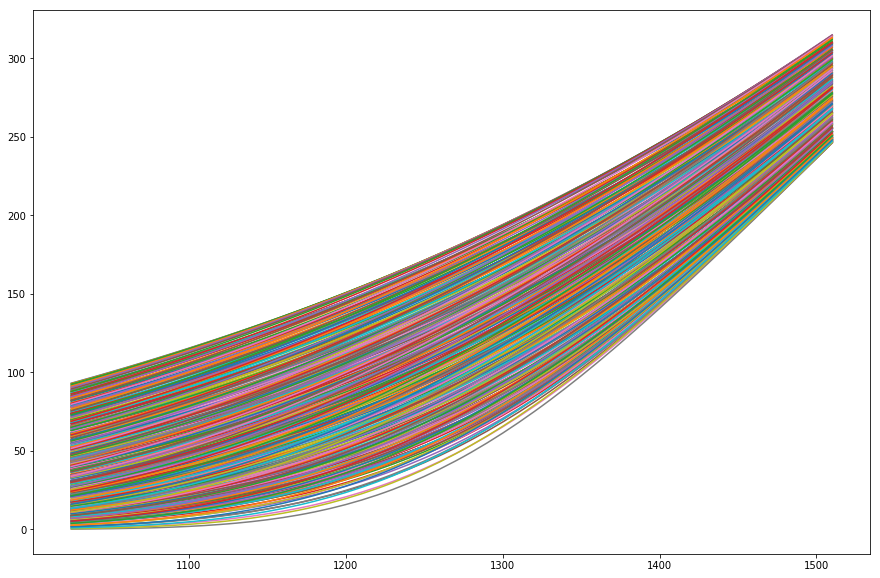

In [108]:
%autoreload

In [22]:
for d in dots:
    print(d)

(9.02008299242, 0.025244456818, 1.80768106728, -0.344713517364, 0.0190331498994)
(9.11645891597, 0.0334380763791, 1.97549692293, -0.436581567279, 0.00719259243993)
(6.05261061367, 0.0337956380611, 1.43958212108, -0.515327200763, 0.0413542099098)
(1.59317271316, 1e-07, 0.512469119781, -0.586893969385, 0.068201829844)
(8.12353730587, 0.0435032632482, 1.94623927045, -0.638631814401, 0.0789392988256)
(6.24813342825, 0.0647295840748, 1.6959327476, -0.694763766487, 0.029759916001)
(6.13862387354, 0.0529442919044, 1.58118135607, -0.746114274935, 0.110111920829)
(6.91169538899, 0.0270755205485, 1.76181427965, -0.759696048515, 0.276784944516)
(4.86060349241, 9.37253434481e-05, 1.17621537667, -0.807696032795, 0.308674003611)
(5.11314136415, 0.124498768518, 1.6977897446, -0.852944139832, 0.00858158076631)
(3.14122498703, 0.083680133529, 1.09842940289, -0.878606803246, 0.135573261956)
(4.38508688842, 0.14339489284, 1.55458744069, -0.920713708186, 0.0511621912945)
(2.33599296894, 0.174373111037, 1.

In [29]:
import numpy as np
grid = np.array(hf.grid(-13, 33, -0.7, 1.5, n=20))

In [30]:
restored = np.array(list(map(
    lambda dot: dot @ components + pca.mean_,
    grid
)))

In [31]:
restored.shape
centers_2d.shape

(497, 2)

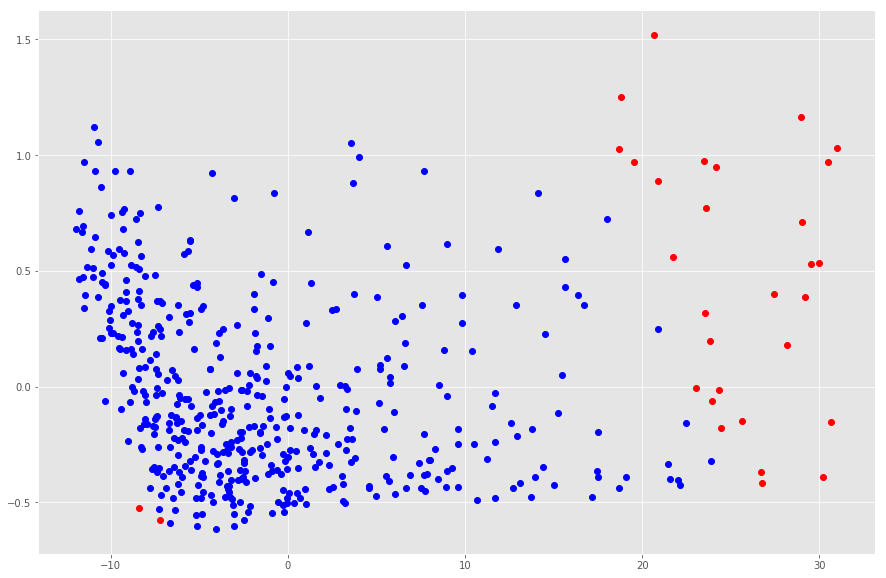

In [32]:
is_bad = np.array(list(map(
    lambda x: dh.bad_pars(x, bounds_only=True, model='heston'),
    restored
)))

good = np.array(grid)[np.logical_not(is_bad)]
bad = np.array(grid)[is_bad]
dh.plot_and_color_2d_params(model='heston', dots=centers_2d, factors=components, means=pca.mean_)

In [33]:
sum(is_bad) / len(grid)

0.32426303854875282

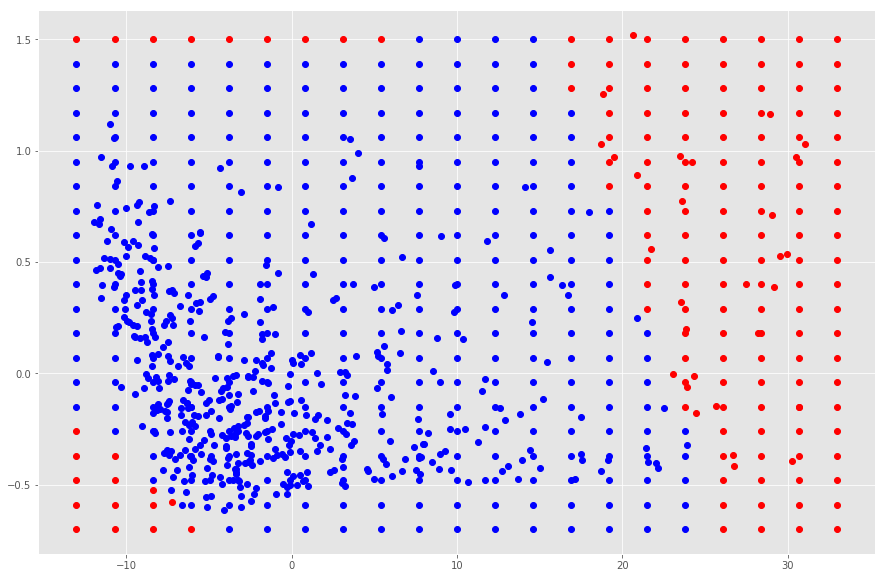

In [37]:
grid = np.array(hf.grid(-13, 33, -0.7, 1.5, n=20))

dh.plot_and_color_2d_params(model='heston', dots=grid, factors=components, 
                            means=pca.mean_, bounds_only=True)
dh.plot_and_color_2d_params(model='heston', dots=centers_2d, factors=components, 
                            means=pca.mean_, bounds_only=True)